### pip installations

In [333]:
import numpy as np
# import starfysh
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import numpy as np
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from attr.validators import min_len
from scipy.spatial import procrustes
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import ot  # POT library for Optimal Transport
import matplotlib.pyplot as plt
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from itertools import permutations
# !pip install starfysh
# !pip install pandas 
# !pip install scanpy
# !pip install histomicstk
# !pip install --upgrade pip setuptools wheel
# !pip install pyvips --use-pep517
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import bar_nick_utils
import importlib
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, get_cell_representations_as_archetypes, preprocess_protein, plot_archetypes, \
get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal

# computationally figure out which ones are best
np.random.seed(8)

### reading in data

In [334]:
adata = sc.read("data/totalVI/spleen_lymph_cite_seq.h5ad")
adata = adata[adata.obs['batch'] == f'SLN111-D1']
# take subsampel of adata
fraction = 0.2
sc.pp.subsample(adata, fraction=fraction)
# adata.obsm['protein_expression'].columns.tolist()

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [335]:
adata.obsm['protein_expression'].values.max()

4601.0

In [336]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

In [337]:
# filtering cell types with low quantity
# need to add this filtering step to synthtic_data_generation.ipynb

# mask = adata.obs['major_cell_types'].isin(['Plasmacytoid dendritic cells', 'Red blood cells', 'Dendritic cells'])
# adata = adata[~mask]


In [338]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        878
CD4 T          407
CD8 T          265
cDCs            43
T cells         38
Treg            28
Macrophages     23
Monocytes       19
NK              19
Neutrophils     13
pDCs             9
RBC              5
Name: count, dtype: int64

### preprocessing RNA protein

In [339]:
adata.X.todense()[:100,:10]
print("Contains NaN:", np.isnan(adata.X.todense()).any())
print("Contains Inf:", np.isinf(adata.X.todense()).any())


Contains NaN: False
Contains Inf: False


In [340]:
# adata_prot = preprocess_protein(adata_prot)
# (adata_rna.X.sum(0).T)
# sc.pp.normalize_total(adata_prot)
# make the X sparse mat integers
# adata.X = adata.X.astype(int)
#

In [341]:
# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
print(f"Selected {adata.shape[1]} highly variable genes.")

# PCA after selecting highly variable genes
sc.pp.pca(adata)
print(
    f"Variance ratio after highly variable gene selection PCA: {adata.uns['pca']['variance_ratio'][:10].sum():.4f}")



Selected 1000 highly variable genes.
Variance ratio after highly variable gene selection PCA: 0.9580


/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [342]:
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
sc.pp.pca(adata_rna)
print(adata_rna.uns['pca']['variance_ratio'][:10].sum())
adata_rna = preprocess_rna(adata_rna)
sc.pp.pca(adata_rna)
print(adata_rna.uns['pca']['variance_ratio'][:10].sum())

adata_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_prot = preprocess_protein(adata_prot)
# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch
# larget_batch = adata_prot.obs['batch'].value_counts().idxmax()

0.95796573
Variance ratio after log transformation PCA: 0.4920
Variance ratio after normalization PCA: 0.4517
0.45165217
Variance ratio after PCA: 0.9272
Variance ratio after normalization PCA: 0.9290
Variance ratio after log transformation PCA: 0.6790


In [343]:
adata_prot.X

array([[3.1799803, 1.2699566, 1.2699566, ..., 1.2699566, 0.8243284,
        2.9404776],
       [4.6524496, 2.5584853, 1.4826584, ..., 0.       , 1.4826584,
        2.252512 ],
       [3.4225087, 1.2853247, 1.0093782, ..., 1.0093782, 1.6789148,
        3.5555177],
       ...,
       [4.138283 , 3.1256514, 0.6456783, ..., 1.532367 , 1.532367 ,
        3.816761 ],
       [2.365667 , 1.2275288, 1.2275288, ..., 1.9504659, 0.7913589,
        2.365667 ],
       [3.225972 , 3.2893915, 1.4579183, ..., 0.7414618, 0.7414618,
        4.2440224]], dtype=float32)

In [344]:
adata = adata_prot

### analysis to get to scatter plot

In [345]:
np.cumsum(adata_prot.uns['pca']['variance_ratio'])



array([0.44068244, 0.5187727 , 0.57377154, 0.6004158 , 0.617206  ,
       0.6332527 , 0.6469329 , 0.65905696, 0.6690764 , 0.67898726,
       0.6873088 , 0.6950774 , 0.7026552 , 0.7100589 , 0.7167742 ,
       0.72299695, 0.7290266 , 0.7348891 , 0.7404119 , 0.74574554,
       0.75083387, 0.7558662 , 0.7607532 , 0.76552755, 0.7702225 ,
       0.77487665, 0.7793525 , 0.7837627 , 0.78812766, 0.79244334,
       0.7967165 , 0.8009826 , 0.8051224 , 0.8092344 , 0.8132659 ,
       0.8172363 , 0.8211984 , 0.8250581 , 0.8288738 , 0.8326508 ,
       0.8363726 , 0.8400413 , 0.8436954 , 0.8473108 , 0.8508688 ,
       0.85438883, 0.85788417, 0.86136484, 0.8647568 , 0.8681356 ],
      dtype=float32)

In [346]:
max_possible_pca_dim_rna = min(adata_rna.X.shape[1], adata_rna.X.shape[0])
max_possible_pca_dim_prot = min(adata_prot.X.shape[1], adata_prot.X.shape[0])
sc.pp.pca(adata_rna,n_comps = max_possible_pca_dim_rna-1)
sc.pp.pca(adata_prot,n_comps = max_possible_pca_dim_prot-1)
# print explain ration var for both
# print(adata_prot.uns['pca']['variance_ratio'][:20].sum())
# print(adata_rna.uns['pca']['variance_ratio'][:20].sum())
# sc.pl.pca_variance_ratio(adata_prot)
# sc.pl.pca_variance_ratio(adata_rna)
# make PCA explain 90% of variance
cumulative_variance_ratio = np.cumsum(adata_rna.uns['pca']['variance_ratio'])
n_comps_90 = np.argmax(cumulative_variance_ratio >= 0.50) + 1
sc.pp.pca(adata_rna, n_comps=n_comps_90)
print(f"Number of components explaining 90% of variance: {n_comps_90}")
sc.pp.pca(adata_prot)
cumulative_variance_ratio = np.cumsum(adata_prot.uns['pca']['variance_ratio'])
n_comps_90 = np.argmax(cumulative_variance_ratio >= 0.50) + 1
sc.pp.pca(adata_prot, n_comps=n_comps_90)
print(f"Number of components explaining 90% of variance: {n_comps_90}")
print( np.cumsum(adata_prot.uns['pca']['variance_ratio']))
print( np.cumsum(adata_rna.uns['pca']['variance_ratio']))
# adata.uns['pca']['variance_ratio'][:10].sum()

Number of components explaining 90% of variance: 50
Number of components explaining 90% of variance: 4
[0.44068274 0.5187731  0.5737719  0.6004162 ]
[0.30585203 0.35767335 0.37763056 0.39333338 0.40815014 0.41982713
 0.42910686 0.43700764 0.44440225 0.45165214 0.45844465 0.46479243
 0.47106022 0.47672758 0.48182997 0.48670945 0.49143597 0.4960772
 0.500404   0.5045478  0.5085974  0.5124781  0.51628053 0.5200313
 0.52371144 0.5272827  0.53079087 0.53423613 0.53762144 0.5409875
 0.5443094  0.5475565  0.5507532  0.5539444  0.55706596 0.56018436
 0.56326926 0.5663112  0.56931096 0.57228744 0.57523865 0.5781435
 0.5810042  0.5838579  0.58668596 0.58949775 0.59225005 0.5949914
 0.5976913  0.600372  ]


In [347]:
archetype_list_protein = []
archetype_list_rna = []
converge=1e-5
min_k = 7
max_k = 11
step_size = 2

evs =[]
X_protein = adata_prot.obsm['X_pca'].T
total = (max_k-min_k)/step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and ev - evs[i-1] < converge:
        print('early stopping')
        break
evs =[]
X_rna = adata_rna.obsm['X_pca'].T

for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    if j>i:
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and ev - evs[j-1] < converge:
        # early stopping
        print('early stopping')
        break
min_len = min([len(archetype_list_protein),len(archetype_list_rna)])
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]

100%|██████████| 2/2.0 [00:03<00:00,  1.78s/it]
100%|██████████| 2/2.0 [00:00<00:00,  2.40it/s]


In [348]:
adata_prot.X[:100,:10].max()

6.2463293

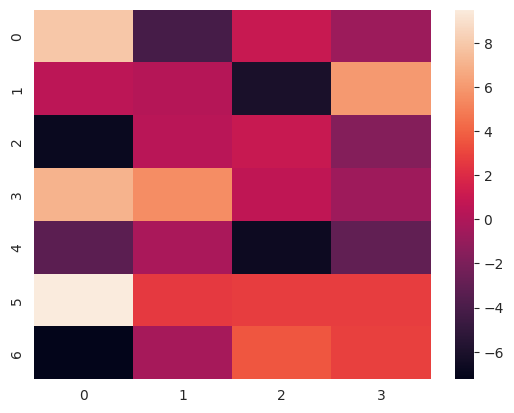

<Axes: >

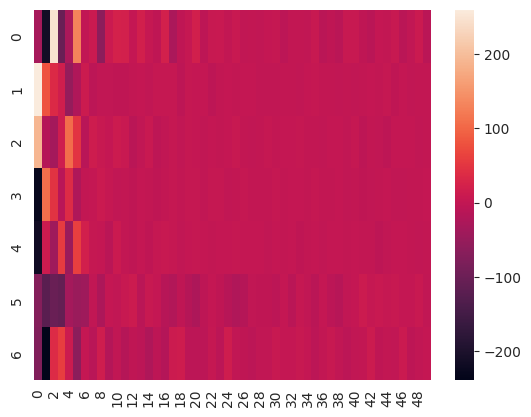

In [349]:
sns.heatmap(archetype_list_protein[0])
plt.show()
sns.heatmap(archetype_list_rna[0])

In [350]:
# send this for gene and protein as well as matching arrays over slack
# loop over prot and rna archetypes and get  weights for each loop over the archetypes
major_cell_types_list = sorted(list(set(adata_prot.obs['major_cell_types'])))
major_cell_types_amount_prot = [adata_prot.obs['major_cell_types'].value_counts()[cell_type] for cell_type in major_cell_types_list]
major_cell_types_amount_rna = [adata_rna.obs['major_cell_types'].value_counts()[cell_type] for cell_type in major_cell_types_list]
assert set(adata_rna.obs['major_cell_types']) == set(adata_prot.obs['major_cell_types'])
archetypes_prot_proportions,archetypes_ran_proportions = [],[]

# weights_prot = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetype_list_protein[0])
# weights_rna = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetype_list_rna[0])
archetype_proportion_list = []

for archetypes_prot,archetypes_rna in tqdm(zip(archetype_list_protein, archetype_list_rna)):
    weights_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot)
    weights_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], archetypes_rna)
    archetypes_dim = archetypes_prot.shape[1]
    archetype_num = archetypes_prot.shape[0]
    prot_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))),columns=major_cell_types_list)
    rna_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))),columns=major_cell_types_list)
    archetype_cell_proportions = np.zeros((archetype_num, len(major_cell_types_list)))
    row_argmax_prot = np.argmax(weights_prot, axis=1)
    row_argmax_rna = np.argmax(weights_rna, axis=1)
    for curr_archetype in range(archetype_num):
        df_rna=pd.DataFrame([weights_prot[:,curr_archetype],adata_rna.obs['major_cell_types'].values],index=['weight','major_cell_types']).T
        df_prot=pd.DataFrame([weights_rna[:,curr_archetype],adata_prot.obs['major_cell_types'].values],index=['weight','major_cell_types']).T
        df_rna = df_rna.groupby('major_cell_types')['weight'].sum()
        df_prot = df_prot.groupby('major_cell_types')['weight'].sum()
        df_rna = df_rna[major_cell_types_list]
        df_prot = df_prot[major_cell_types_list]
        # normalize by the amount of major cell types
        rna_arch_prop.loc[curr_archetype,:] =df_rna.values/major_cell_types_amount_rna 
        prot_arch_prop.loc[curr_archetype,:] =df_prot.values/major_cell_types_amount_prot

    prot_arch_prop = (prot_arch_prop.T / prot_arch_prop.sum(1)).T
    prot_arch_prop = prot_arch_prop / prot_arch_prop.sum(0)
    rna_arch_prop = (rna_arch_prop.T / rna_arch_prop.sum(1)).T
    rna_arch_prop = rna_arch_prop / rna_arch_prop.sum(0)

    archetype_proportion_list.append([prot_arch_prop.copy(),rna_arch_prop.copy()])

2it [00:34, 17.05s/it]


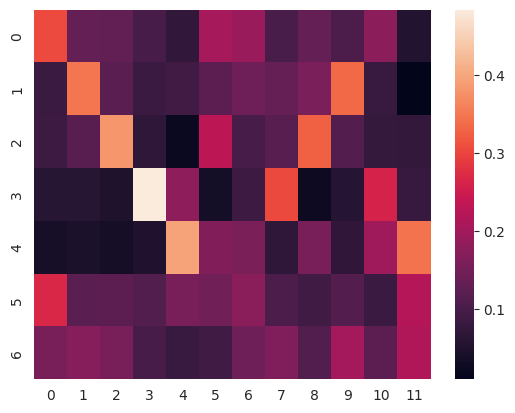

<Axes: >

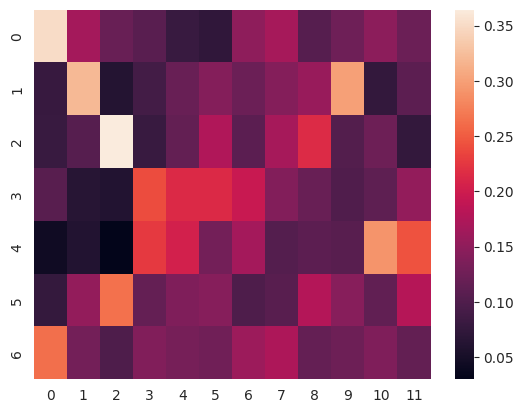

In [351]:
# normlize archetype_proportion_list cols
def nn(norm):
    norm = (norm.T / norm.sum(1)).T
    norm = norm / norm.sum(0)
    return norm
norm_1 = nn(archetype_proportion_list[0][0])
norm_2 = nn(archetype_proportion_list[0][1])
sns.heatmap(reorder_rows_to_maximize_diagonal(norm_1.values)[0])
plt.show()
sns.heatmap(reorder_rows_to_maximize_diagonal(norm_2.values)[0])
# major_cell_types_amount 

In [352]:

def match_rows(rna, protein, metric='cosine'):
    """
    Find the best matching between rows of RNA and Protein matrices.

    Parameters:
    -----------
    rna : np.ndarray
        RNA matrix, shape (n_samples, n_features).
    protein : np.ndarray
        Protein matrix, shape (n_samples, n_features).
    metric : str, optional
        Distance metric to use ('euclidean' or 'cosine').

    Returns:
    --------
    row_ind : np.ndarray
        Indices of the RNA rows.
    col_ind : np.ndarray
        Indices of the Protein rows matched to RNA rows.
    normalized_cost : float
        Total matching cost normalized by the number of archetypes (n_samples).
    """
    # Compute the cost matrix between rows
    cost_matrix = cdist(rna, protein, metric=metric)
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Calculate the total matching cost
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # Normalize the total cost by the number of archetypes (n_samples)
    n_archetypes = rna.shape[0]
    normalized_cost = total_cost / n_archetypes
    
    return row_ind, col_ind, normalized_cost
def find_best_pair_by_row_matching(archetype_proportion_list, metric='cosine'):
    """
    Find the best index in the list by matching rows using linear assignment.

    Parameters:
    -----------
    archetype_proportion_list : list of tuples
        List where each tuple contains (rna, protein) matrices.
    metric : str, optional
        Distance metric to use ('euc    lidean' or 'cosine').

    Returns:
    --------
    best_index : int
        Index of the best matching pair in the list.
    best_total_cost : float
        Total cost of the best matching.
    best_row_ind : np.ndarray
        Indices of RNA rows.
    best_col_ind : np.ndarray
        Indices of Protein rows matched to RNA rows.
    """
    best_index = None
    best_total_cost = float('inf')
    best_row_ind = None
    best_col_ind = None

    for i, (rna, protein) in enumerate(archetype_proportion_list):
        rna = rna.values if hasattr(rna, 'values') else rna
        protein = protein.values if hasattr(protein, 'values') else protein

        assert rna.shape[1] == protein.shape[1], f"Mismatch in dimensions at index {i}."

        row_ind, col_ind, total_cost = match_rows(rna, protein, metric=metric)
        print(f"Pair {i}: Total matching cost = {total_cost}")

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_index = i
            best_row_ind = row_ind
            best_col_ind = col_ind

    return best_index, best_total_cost, best_row_ind, best_col_ind

best_index, best_total_cost, best_row_ind, best_col_ind = find_best_pair_by_row_matching(
    archetype_proportion_list, metric='cosine'
)

print("\nBest pair found:")
print(f"Best index: {best_index}")
print(f"Best total matching cost: {best_total_cost}")
print(f"Row indices (RNA): {best_row_ind}")
print(f"Matched row indices (Protein): {best_col_ind}")


Pair 0: Total matching cost = 0.08037839476973566
Pair 1: Total matching cost = 0.13153636247768588

Best pair found:
Best index: 0
Best total matching cost: 0.08037839476973566
Row indices (RNA): [0 1 2 3 4 5 6]
Matched row indices (Protein): [4 2 6 0 3 5 1]


Optimal normalized matching cost: 0.0804


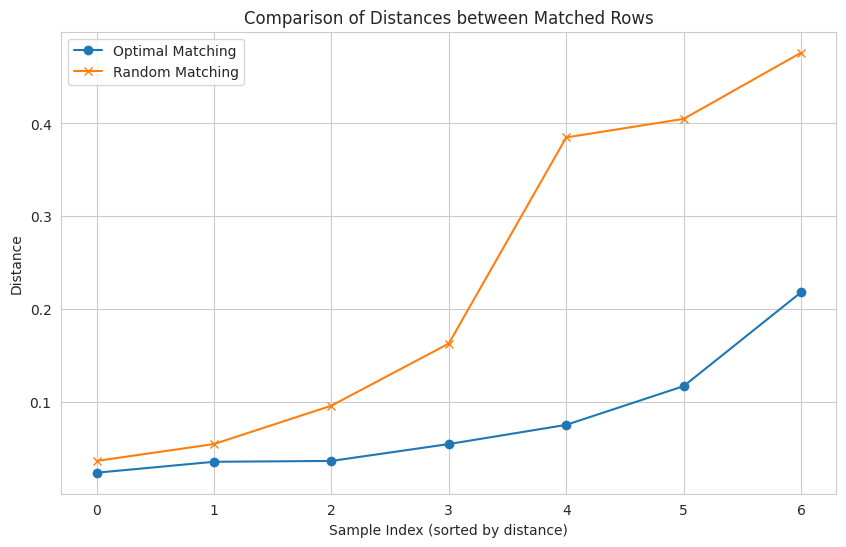

Average random matching cost over 100 trials: 0.2259
Standard deviation: 0.0403


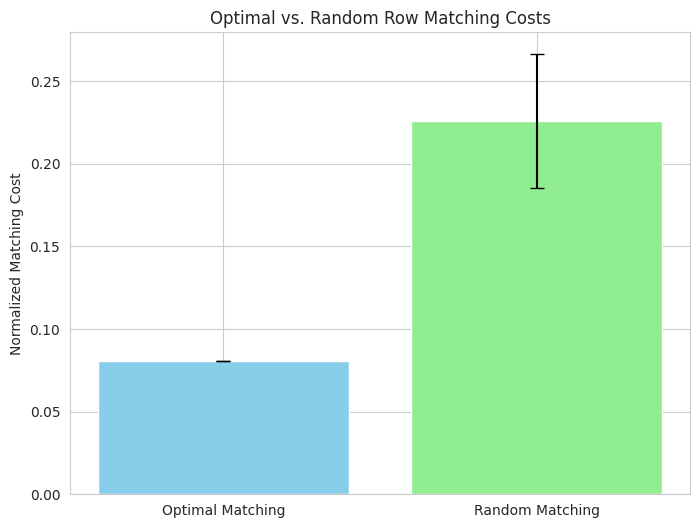

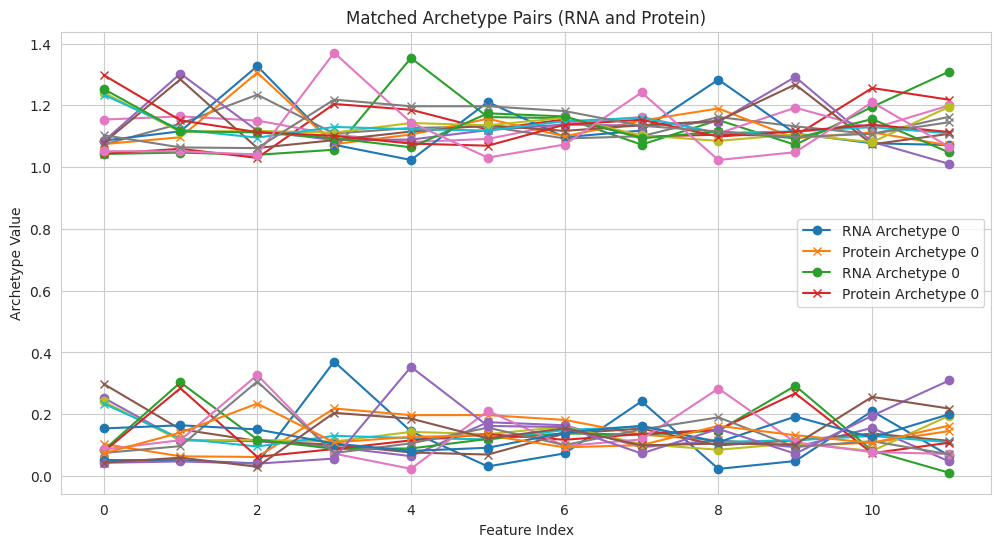

In [353]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def match_rows(rna, protein, metric='cosine'):
    """Find the optimal matching between RNA and Protein rows."""
    # Compute the cost matrix between rows
    cost_matrix = cdist(rna, protein, metric=metric)
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Calculate the total matching cost
    total_cost = cost_matrix[row_ind, col_ind].sum()
    # Normalize the total cost by the number of archetypes (n_samples)
    n_archetypes = rna.shape[0]
    normalized_cost = total_cost / n_archetypes
    return row_ind, col_ind, normalized_cost, cost_matrix

def compute_random_matching_cost(rna, protein, metric='cosine'):
    """Compute normalized cost and distances for a random row assignment."""
    n_samples = rna.shape[0]
    random_indices = np.random.permutation(n_samples)
    protein_random = protein[random_indices]
    
    if metric == 'euclidean':
        distances = np.linalg.norm(rna - protein_random, axis=1)
    elif metric == 'cosine':
        # Normalize rows to compute cosine similarity
        rna_norm = rna / np.linalg.norm(rna, axis=1, keepdims=True)
        protein_random_norm = protein_random / np.linalg.norm(protein_random, axis=1, keepdims=True)
        cosine_similarity = np.sum(rna_norm * protein_random_norm, axis=1)
        distances = 1 - cosine_similarity  # Cosine distance
    else:
        raise ValueError("Unsupported metric. Use 'euclidean' or 'cosine'.")
    
    normalized_cost = np.sum(distances) / n_samples
    return normalized_cost, distances

def compare_matchings(archetype_proportion_list, metric='cosine', num_trials=100):
    """Compare optimal matching cost with average random matching cost and plot norms."""
    # Extract the best pair based on optimal matching
    best_cost = float('inf')
    for i, (rna, protein) in enumerate(archetype_proportion_list):
        rna = rna.values if hasattr(rna, 'values') else rna
        protein = protein.values if hasattr(protein, 'values') else protein
        row_ind, col_ind, cost, cost_matrix = match_rows(rna, protein, metric)
        if cost < best_cost:
            best_cost = cost
            best_rna, best_protein = rna, protein
            best_row_ind, best_col_ind = row_ind, col_ind
            best_cost_matrix = cost_matrix
    print(f"Optimal normalized matching cost: {best_cost:.4f}")

    # Compute distances for the optimal matching
    optimal_distances = best_cost_matrix[best_row_ind, best_col_ind]

    # Compute distances for a single random matching
    random_cost, random_distances = compute_random_matching_cost(best_rna, best_protein, metric)

    # Visualization of distances
    n_samples = best_rna.shape[0]
    indices = np.arange(n_samples)

    plt.figure(figsize=(10, 6))
    plt.plot(indices, np.sort(optimal_distances), label='Optimal Matching', marker='o')
    plt.plot(indices, np.sort(random_distances), label='Random Matching', marker='x')
    plt.xlabel('Sample Index (sorted by distance)')
    plt.ylabel('Distance')
    plt.title('Comparison of Distances between Matched Rows')
    plt.legend()
    plt.show()

    # Compute average random matching cost over multiple trials
    random_costs = []
    for _ in range(num_trials):
        cost, _ = compute_random_matching_cost(best_rna, best_protein, metric)
        random_costs.append(cost)
    avg_random_cost = np.mean(random_costs)
    std_random_cost = np.std(random_costs)
    print(f"Average random matching cost over {num_trials} trials: {avg_random_cost:.4f}")
    print(f"Standard deviation: {std_random_cost:.4f}")

    # Bar plot of normalized matching costs
    labels = ['Optimal Matching', 'Random Matching']
    costs = [best_cost, avg_random_cost]
    errors = [0, std_random_cost]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, costs, yerr=errors, capsize=5, color=['skyblue', 'lightgreen'])
    plt.ylabel('Normalized Matching Cost')
    plt.title('Optimal vs. Random Row Matching Costs')
    plt.show()

    # Plot matched pairs
    plt.figure(figsize=(12, 6))
    n_archetypes = best_rna.shape[0]
    for i in range(n_archetypes):
        rna_values = best_rna[best_row_ind[i]]
        protein_values = best_protein[best_col_ind[i]]
        archetype_indices = np.arange(len(rna_values))
        plt.plot(archetype_indices, np.log1p(rna_values), marker='o', label=f'RNA Archetype {i}' if i == 0 else "")
        plt.plot(archetype_indices, np.log1p(protein_values), marker='x', label=f'Protein Archetype {i}' if i == 0 else "")
        rna_values = best_rna[best_row_ind[::-1][i]]
        protein_values = best_protein[best_col_ind[::-1][i]]
        plt.plot(archetype_indices, np.log1p(rna_values)+1, marker='o', label=f'RNA Archetype {i}' if i == 0 else "")
        plt.plot(archetype_indices, np.log1p(protein_values)+1, marker='x', label=f'Protein Archetype {i}' if i == 0 else "")
        plt.legend()
    plt.xlabel('Feature Index')
    plt.ylabel('Archetype Value')
    plt.title('Matched Archetype Pairs (RNA and Protein)')
    plt.show()

# Example usage
# archetype_proportion_list should be a list of (rna_matrix, protein_matrix) tuples
compare_matchings(archetype_proportion_list, metric='cosine', num_trials=100)


In [354]:
# get all cells archtype vec and see how they match
# best_rna_archetype, best_protein_archetype = archetype_proportion_list[best_index]
# weights = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], best_protein_archetype.T)
# best_rna_archetype, best_protein_archetype = archetype_proportion_list[best_index]
# best_rna_archetype.shape
best_archetype_rna,best_archetype_prot = archetype_list_rna[best_index],archetype_list_protein[best_index]
# best_archetype_rna.shape, best_archetype_prot.shape
best_rna_archetype= best_archetype_rna[best_row_ind,:]
best_protein_archetype = best_archetype_prot[best_col_ind,:]
rna_archetype_vecs = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], best_rna_archetype)
protein_archetype_vecs = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], best_protein_archetype)

# major_cell_types_amount 

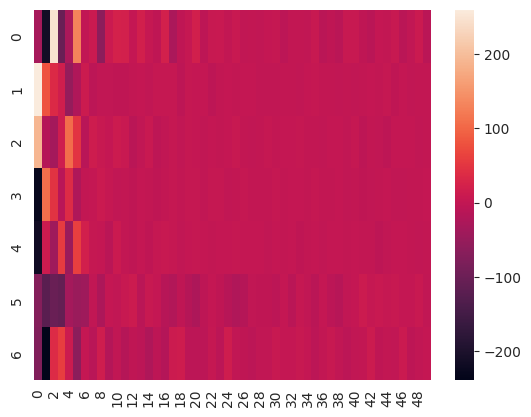

array([[-3.28346957, -0.18416051, -6.71945001, -3.03853673],
       [-6.83790112,  0.38663614,  0.9704212 , -1.64037454],
       [-7.24759337, -0.32613098,  3.59599046,  2.8718411 ],
       [ 7.89087117, -4.13216353,  0.97440703, -0.72212073],
       [ 7.07095512,  5.53052906,  0.6292964 , -0.65583002],
       [ 9.5005703 ,  2.61016941,  2.72447157,  2.70226812],
       [ 0.48438154,  0.2526924 , -6.09547986,  6.03000803]])

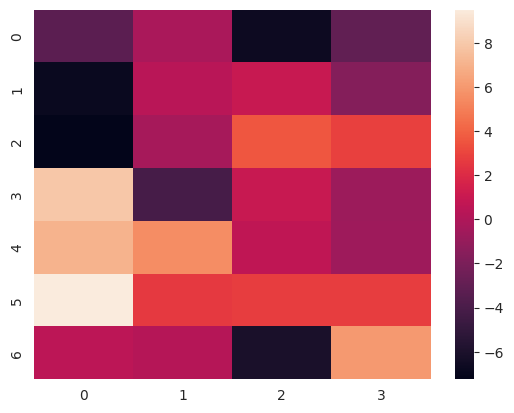

In [355]:
sns.heatmap(best_rna_archetype)
plt.show()
sns.heatmap(best_protein_archetype)
best_protein_archetype

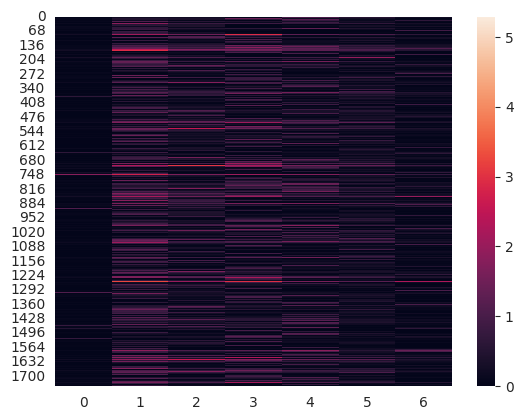

In [356]:
# rna_archetype_vecs = (rna_archetype_vecs -    rna_archetype_vecs.mean()) / rna_archetype_vecs.std()
protein_archetype_vecs = (protein_archetype_vecs - protein_archetype_vecs.mean()) / protein_archetype_vecs.std()
sns.heatmap((rna_archetype_vecs))
plt.show()
# sns.heatmap(np.log1p(protein_archetype_vecs))
# plt.show()

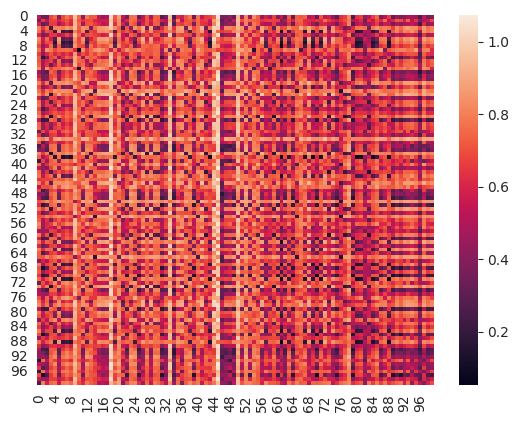

In [357]:

archetype_distances = scipy.spatial.distance.cdist(rna_archetype_vecs,
                                                   protein_archetype_vecs,metric='cosine')
                                                   # adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
matching_cells = np.argmin(archetype_distances,axis=1)
# adata_prot_subset = adata_prot_subset[matching_cells] # this make sure that the cells are aligned!
# adata_rna_subset.obs['matching_protein_cells'] = matching_cells
sns.heatmap(np.log1p(archetype_distances[:100,:100]))
plt.show()


could not find match for archetypes of length 7 
could not find match for archetypes of length 9 


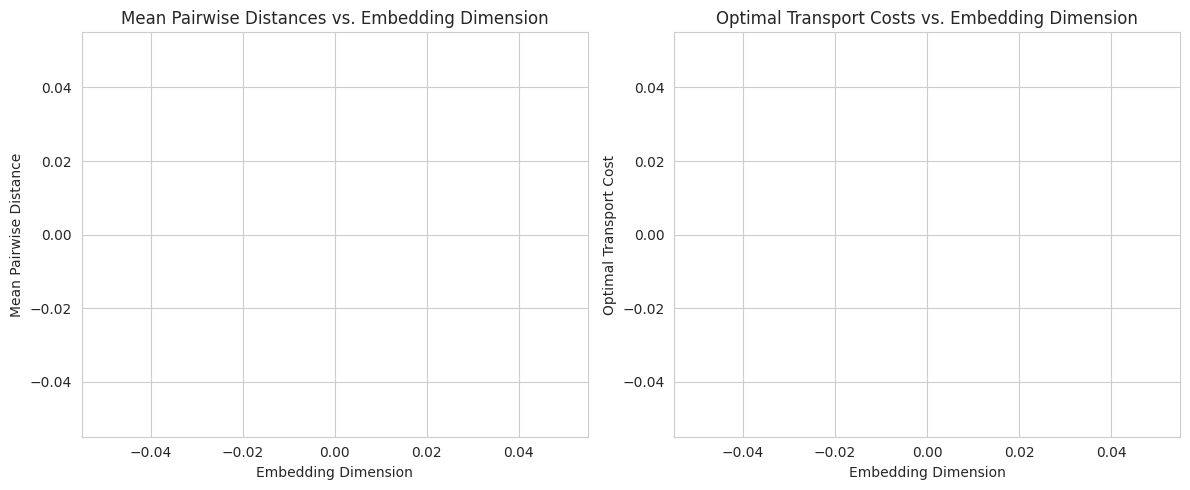

ValueError: attempt to get argmin of an empty sequence

In [358]:
embedding_dimensions = []  # Example dimensions from n to m
mean_pairwise_distances = []
ot_costs = []
metric = 'cosine'  # 'euclidean' or 'cosine'
# Number of samples in your datasets

# Loop over each embedding dimension
for archetypes_prot,archetypes_ran in (archetype_proportion_list):
    try:
        ds1_embeddings = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes_prot)
        ds2_embeddings = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetypes_ran)
    except:
        print(f'could not find match for archetypes of length {len(archetypes_prot)} ')
        continue
    
    embedding_dimensions.append(len(archetypes_prot))
    n_samples = ds1_embeddings.shape[0]    
    # Standardize embeddings
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    ds1_embeddings = scaler1.fit_transform(ds1_embeddings)
    ds2_embeddings = scaler2.fit_transform(ds2_embeddings)
    
    # Step 2: Align Dimensions using Procrustes Analysis
    mtx1, mtx2, disparity = procrustes(ds1_embeddings, ds2_embeddings)
    # mtx1 and mtx2 are the aligned embeddings
    
    # Alternative: Align Dimensions using CCA
    # cca = CCA(n_components=dim)
    # ds1_embeddings_cca, ds2_embeddings_cca = cca.fit_transform(ds1_embeddings, ds2_embeddings)
    # Use ds1_embeddings_cca and ds2_embeddings_cca for further calculations
    
    # Step 3: Compute Pairwise Distances between corresponding samples
    pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1,metric='cosine')
    
    if metric == 'euclidean':
        pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1)
    elif metric == 'cosine':
        # Normalize rows to compute cosine similarity
        rna_norm = mtx1 / np.linalg.norm(mtx1, axis=1, keepdims=True)
        protein_random_norm = mtx2 / np.linalg.norm(mtx2, axis=1, keepdims=True)
        cosine_similarity = np.sum(rna_norm * protein_random_norm, axis=1)
        pairwise_distances = 1 - cosine_similarity  # Cosine distance
    else:
        raise ValueError("Unsupported metric. Use 'euclidean' or 'cosine'.")

    mean_distance = np.mean(pairwise_distances)
    mean_pairwise_distances.append(mean_distance)
    print(f"Mean Pairwise Distance: {mean_distance}")
    
    # Step 4: Compute Optimal Transport Cost
    # Create cost matrix between all samples (optional, since datasets are coupled)
    cost_matrix = cdist(mtx1, mtx2, metric='cosine')
    
    # Since datasets are coupled, create uniform distributions
    a = np.ones(n_samples) / n_samples
    b = np.ones(n_samples) / n_samples
    
    # Compute OT cost using Sinkhorn algorithm
    lambda_reg = 1e-3  # Entropic regularization parameter
    ot_cost = ot.sinkhorn2(a, b, cost_matrix, lambda_reg)
    ot_costs.append(ot_cost)
    print(f"Optimal Transport Cost: {ot_cost}")
    print("-" * 50)

# Step 5: Compare Embedding Spaces
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(embedding_dimensions, mean_pairwise_distances, marker='o')
plt.title('Mean Pairwise Distances vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Mean Pairwise Distance')

plt.subplot(1, 2, 2)
plt.plot(embedding_dimensions, ot_costs, marker='o', color='red')
plt.title('Optimal Transport Costs vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Optimal Transport Cost')

plt.tight_layout()
plt.show()

# Identify the best embedding space
best_dimension_index = np.argmin(mean_pairwise_distances)
best_embedding_dimension = embedding_dimensions[best_dimension_index]
print(f"The best embedding dimension based on mean pairwise distance is: {best_embedding_dimension}")

best_ot_index = np.argmin(ot_costs)
best_ot_dimension = embedding_dimensions[best_ot_index]
print(f"The best embedding dimension based on OT cost is: {best_ot_dimension}")


In [ ]:
# np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))
np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))

In [ ]:
def plot_scatter(mtx1, mtx2):
    pca = PCA(n_components=2)
    embeddings_combined = np.vstack((mtx1, mtx2))
    tsne_results = pca.fit_transform(embeddings_combined)
    # tsne_results = pca.fit_transform(embeddings_combined)

    labels = ['Dataset 1'] * n_samples + ['Dataset 2'] * n_samples
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Dataset'] = labels

    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Dataset', data=df)
    plt.title('t-SNE of Aligned Embeddings')
    plt.show()



In [ ]:

X = count.T
archetype, _, _, _, ev = PCHA(X, noc=len(set(adata.obs['major_cell_types'])))
# archetype = archetype.T
archetype.shape

In [ ]:
# # weights = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes[-1].T)
# distances_array = []
# for arche in archetype:
#     distances = np.linalg.norm(adata_prot.obsm['X_pca']- arche, axis=1)
#     distances_array.append(distances)
# # np.linalg.norm(adata.obsm['X_pca'],archetype.T)
#     
# 
# # Columns: Cell 1 Cell 2 Cell 3 Cell 4
# # Row: anchor 
# # column, row distance from cell to anchor
# # we want minimum
# distances_array = np.array(distances_array)
# distances_array = distances_array.T
# row_argmin = np.argmin(distances_array, axis=1)
# adata.obs['archetype'] = row_argmin

### weights

In [ ]:
# send this for gene and protein as well as matching arrays over slack
weights = get_cell_representations_as_archetypes_cvxpy(adata.obsm['X_pca'], archetype.T)
weights_df = pd.DataFrame(weights)
weights_df.to_csv("rna_weights.csv")
row_argmax = np.argmax(weights, axis=1)
adata.obs['corr_archetype'] = row_argmax
len(set((adata.obs['major_cell_types'])))


In [ ]:
# set(list(adata.obs['major_cell_types']))
(set(cell_type_mapping.keys())) == ((set(adata.obs['cell_types'])))

In [ ]:
# once I have indices, I want to check cell type for all of the indices
for dictionary in archetype_proportion_list:
    print(dictionary)


In [ ]:
# gene protein mapping
gene_mapping = ['Monocytes', 'T cells-2', 'T cells-1', 'Macrophages', 'Neutrophils', 'Red blood cells',
                'Natural killer cells', 'Conventional dendritic cells', 'Regulatory T cells', 'Dendritic cells',
                'Natural killer T cells', 'Plasmacytoid dendritic cells', 'B cells']

In [ ]:
# final protein mapping
protein_mapping = ['Red blood cells', 'T cells-2', 'Plasmacytoid dendritic cells', 'Natural killer T cells',
                   'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes',
                   'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [ ]:
assert len(protein_mapping) == len(set(protein_mapping))

In [ ]:
# protein_mapping = ['Red blood cells', 'Natural killer T cells', 'T cells-2', 'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [ ]:
# MUST SAVE
# protein_mapping = ['Red blood cells','Plasmacytoid dendritic cells', 'T cells-2','Natural killer cells', 'Natural killer T cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells','B cells', 'T cells-1' ]

print(len(set(list(protein_mapping))))

In [ ]:
for i in set(adata.obs['major_cell_types']):
    if i not in gene_mapping:
        print(i)
# print(len(protein_mapping))
# print(len(set(protein_mapping)))

In [ ]:
cell_type_mapping_order = sorted(set(cell_type_mapping.values()))  # order that we set dimensions

In [ ]:
data_points = adata.obsm['X_pca']
samples_cell_types = list(pd.Categorical(adata.obs['cell_types']))
samples_cell_types = list(pd.Categorical(adata.obs['major_cell_types']))
# samples_cell_types = list(adata.obs['corr_archetype'].astype(str)) #  to see the most correlated cells to each archetype
archetype = archetype_list_protein[2]
samples_cell_types = list(np.argmax(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetype_list_protein[0]),axis=1).astype(np.str_))
plot_archetypes(data_points,archetype,samples_cell_types)
plot_archetypes(data_points,archetype,samples_cell_types)


In [ ]:
# sc.pl.pca(adata, color='major_cell_types')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
# adata.obs['archetype'] = pd.Categorical(adata.obs['archetype'])
adata.obs['corr_archetype'] = pd.Categorical(adata.obs['corr_archetype'])
sc.pl.umap(adata, color=['major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.pca(adata, color=['archetype', 'major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.umap(adata, color='major_cell_types', title='Protein Major Cell Types')

In [ ]:
sc.pl.umap(adata, color='cell_types', title='Protein Minor Cell Types')

In [ ]:
archetypes[-1].shape
# two samples, first dimension: x, second dimension: y

In [ ]:
sc.pl.pca(adata_slice, color='')

In [ ]:
adata.uns['cell_types'] = adata.obs['cell_types']